## Make the mountain plot

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns

In [2]:
new_title_lookup = {'predictive': 'output injection', 'feature': 'input injection'}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

In [ ]:
uniform = True
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]

'''
inject_type_list = ["predictive"]
data_dim_list = ["2D"]
model_type = ["DE"]
noise_list = ["low"]
'''


# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#ED6A5A", "#292F36"]
size_df_linear = 10000 # 1000
size_df_image = 175000
epoch = 99
ensemble = True
n_models = 15

mega_dict = {}

# Nested loops to fill the dictionary
for noise in noise_list:
    mega_dict[noise] = {}  # Create a sub-dictionary for each noise level
    for model in model_type:
        mega_dict[noise][model] = {}  # Create a sub-dictionary for each model type
        for dim in data_dim_list:
            mega_dict[noise][model][dim] = {}  # Create a sub-dictionary for each data dimension
            for inject_type in inject_type_list:
                mega_dict[noise][model][dim][inject_type] = []

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
for n, noise in enumerate(noise_list):
    for m, model in enumerate(model_type):
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):

                chk = 0
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.01, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                if uniform:
                    model_inputs, model_outputs = DataPreparation.select_uniform(
                        model_inputs, model_outputs, dim, verbose=False, rs=40
                    )
                x_test = model_inputs
                y_test = model_outputs
                
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_DER_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        #print('loading this file', file_name)
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        #print("cannot find this model", file_name)
                        continue
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    setupmodel.eval()

                    y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(abs(beta * (1 + nu) / (alpha * nu)))
                    
                    
                elif model == "DE":
                    models_used = 0
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al = []
                    for m in range(n_models):
                        if models_used > 9:
                            break
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            #print('loading this file', file_name)
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            # print("cannot find this model", file_name)
                            continue
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        setupmodel.eval()
                        y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                        # for some reason if the model fails it predicts
                        # really large values for sigma
                        
                        if np.all(y_pred[:, 1] == y_pred[0, 1]) or np.mean(np.sqrt(y_pred[:, 1])) > 0.2:
                            # All values are the same
                            print("All values in y_pred[:,1] are the same or they are really high")
                            # then we need to skip this model
                            print('not using this model ', m)
                            continue
                        else:
                            '''
                            plt.clf()
                            plt.hist(np.sqrt(y_pred[:, 1]), bins=100)
                            plt.title(f'model m {m}')
                            plt.show()
                            '''
                            print('using this model', m)
                            models_used += 1
                            #print('using this model ', m)            
                        u_al_one = np.sqrt(y_pred[:, 1])
                        u_al.append(u_al_one)

                        
                # populate the mega dict
                mega_dict[noise][model][dim][inject_type] = u_al




number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_23666/798972974.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


using this model 6
using this model 7
using this model 8
using this model 9
number of sims 10000
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6
using this model 7
using this model 8
using this model 9
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
All values in y_pred[:,1] are the same or they are really high
not using this model  6
using this model 7
using this model 8
using this model 9
using this model 10


In [ ]:
print('mega dict', mega_dict)

/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rnevin/Library/Caches/pypoetry/virtual

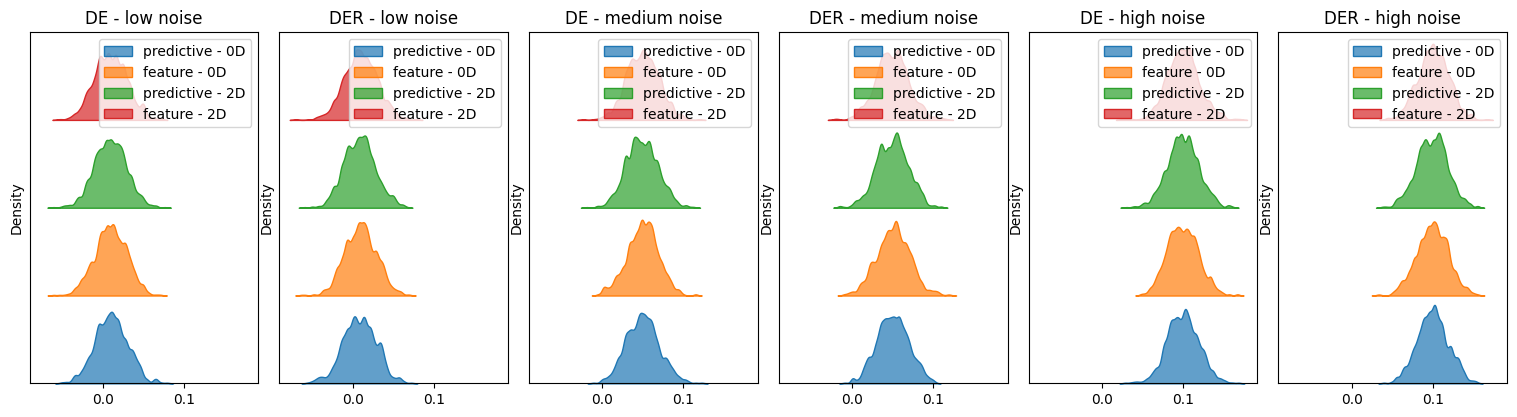

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example setup, use your actual data/model outputs
noise_list = ["low", "medium", "high"]
model_type = ["DE", "DER"]
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]

# Set up figure and axes
fig, axes = plt.subplots(1, len(model_type) * len(noise_list), figsize=(15, 4), sharex=True)
axes = axes.flatten()
index = 0
offset_value = 25

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}



    
for n, noise in enumerate(noise_list):
    for m, model in enumerate(model_type):
        ax = axes[index]
        y_offset = 0  # Initialize the y-offset for stacking
        
        
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):
                # Generate or load aleatoric uncertainty data (replace with your own logic)
                u_al_data = np.random.normal(loc=sigma_y_lookup[noise], scale=0.02, size=1000)
                
                # Plot the KDE with fill=True
                kde = sns.kdeplot(u_al_data, fill=True, bw_adjust=0.5, alpha=0.7, ax=ax,
                                  clip_on=False, label=f"{inject_type} - {dim}", 
                                  color=f'C{j*len(inject_type_list)+i}')
                
                # Get the filled PolyCollection object and adjust its vertices
                poly = ax.collections[-1]
                paths = poly.get_paths()
                
                for path in paths:
                    vertices = path.vertices
                    vertices[:, 1] += y_offset  # Offset the y-values of the vertices

                y_offset += offset_value  # Adjust the y-offset for stacking the next KDE plot

        ax.set_title(f'{model} - {noise} noise')
        ax.legend(loc='upper right')
        ax.set_yticks([])  # Hide y-ticks since they don't have meaningful values now
        ax.set_ylim([0, 4 * offset_value])
        index += 1

# Adjust layout and save the plot
plt.tight_layout(pad=0.1)
plt.savefig(f'../../../Desktop/sigma_in_sigma_out_mountainplot_ensemble_{n_models}_uniform.png', dpi=1000)
